In [1]:
import numpy as np

## Reading and preparing data

In [2]:
def read_dataset():
    import os
    import tarfile
    from scipy.ndimage import imread
    from keras.utils import np_utils
    dataset = {}
    img_shape = None
    with tarfile.open('notmnist_data.tar.gz', 'r:gz') as tar_file:
        cnt = 0
        for f in tar_file:
            if cnt % 1000 == 0:
                print("Pictures read: {}".format(cnt))
            cnt += 1
            if os.path.splitext(f.name)[1] != '.png' or f.size <= 0:
                continue
            clazz_char = os.path.split(os.path.dirname(f.name))[1]
            clazz = ord(clazz_char) - ord('A')
            if clazz not in dataset:
                dataset[clazz] = []
            img = imread(tar_file.extractfile(f))
            if img_shape is None:
                img_shape = img.shape
            if img.shape != img_shape:
                print("Err: images are not of the same shape")
            dataset[clazz].append(img)
        nb_classes = len(dataset)
        for clazz in dataset:
                dataset[clazz] = (np.array(dataset[clazz]), 
                                  np_utils.to_categorical([clazz]*len(dataset[clazz]), nb_classes))
    
    print("Done")
    return (img_shape, dataset)

    
(img_shape, dataset) = read_dataset()
nb_classes = len(dataset)

print("Number of classes = {}".format(nb_classes))
print("Image shape = {}".format(img_shape))

Using Theano backend.


Pictures read: 0
Pictures read: 1000
Pictures read: 2000
Pictures read: 3000
Pictures read: 4000
Pictures read: 5000
Pictures read: 6000
Pictures read: 7000
Pictures read: 8000
Pictures read: 9000
Pictures read: 10000
Pictures read: 11000
Pictures read: 12000
Pictures read: 13000
Pictures read: 14000
Pictures read: 15000
Pictures read: 16000
Pictures read: 17000
Pictures read: 18000
Done
Number of classes = 10
Image shape = (28, 28)


In [3]:
def shuffled(arrays):
    from operator import itemgetter
    arr_len = arrays[0].shape[0]
    p = np.random.permutation(arr_len)
    return map(itemgetter(p), arrays)

def prepare(dataset):
    lbl = ['train', 'validate', 'test']
    xs = {lbl[0]: [], lbl[1]: [], lbl[2]: []}
    ys = {lbl[0]: [], lbl[1]: [], lbl[2]: []}

    for clazz, (X, Y) in dataset.items():
        X, Y = shuffled([X, Y])

        sz = len(X)
        bds = [int(np.ceil(sz * 0.8)), int(np.ceil(sz * 0.9))]
        
        cur_xs = {}
        cur_xs[lbl[0]], cur_xs[lbl[1]], cur_xs[lbl[2]] = np.split(X, bds)
        cur_ys = {}
        cur_ys[lbl[0]], cur_ys[lbl[1]], cur_ys[lbl[2]] = np.split(Y, bds)
        for label in lbl:
            xs[label].extend(cur_xs[label])
            ys[label].extend(cur_ys[label])

    result = {}
    for label in lbl:
        result[label] = shuffled([np.array(xs[label]), np.array(ys[label])])
    
    return result
           

prepared = prepare(dataset)

x_train, y_train = prepared['train']
x_validate, y_validate = prepared['validate']
x_test, y_test = prepared['test']

In [4]:
def plot_history(train_history):
    import matplotlib.pyplot as plt
    
    epoch = train_history.epoch
    history = train_history.history
    
    plt.plot(epoch, history['acc'], 'r', label='acc')
    plt.plot(epoch, history['val_acc'], 'g', label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.legend(loc='lower right')
    plt.show()

## Model 1. One layer

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten

In [140]:
model_1 = Sequential([
        Flatten(input_shape=img_shape),
        Dense(10, activation='softmax')
    ])
model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model_1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_10 (Flatten)             (None, 784)           0           flatten_input_10[0][0]           
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 10)            7850        flatten_10[0][0]                 
Total params: 7850
____________________________________________________________________________________________________


In [141]:
history_1 = model_1.fit(x_train, y_train, batch_size=128, nb_epoch=40, verbose=1, 
            validation_data=(x_validate, y_validate))

Train on 14984 samples, validate on 1870 samples
Epoch 1/40
14984/14984 [==============================] - 0s - loss: 13.8414 - acc: 0.1410 - val_loss: 13.2906 - val_acc: 0.1743
Epoch 2/40
14984/14984 [==============================] - 0s - loss: 13.1276 - acc: 0.1853 - val_loss: 13.1444 - val_acc: 0.1845
Epoch 3/40
14984/14984 [==============================] - 0s - loss: 12.9320 - acc: 0.1976 - val_loss: 12.9197 - val_acc: 0.1973
Epoch 4/40
14984/14984 [==============================] - 0s - loss: 12.8226 - acc: 0.2043 - val_loss: 13.0754 - val_acc: 0.1888
Epoch 5/40
14984/14984 [==============================] - 0s - loss: 11.9723 - acc: 0.2567 - val_loss: 11.7134 - val_acc: 0.2733
Epoch 6/40
14984/14984 [==============================] - 0s - loss: 11.6906 - acc: 0.2745 - val_loss: 11.8692 - val_acc: 0.2631
Epoch 7/40
14984/14984 [==============================] - 0s - loss: 11.7363 - acc: 0.2716 - val_loss: 11.8874 - val_acc: 0.2620
Epoch 8/40
14984/14984 [========================

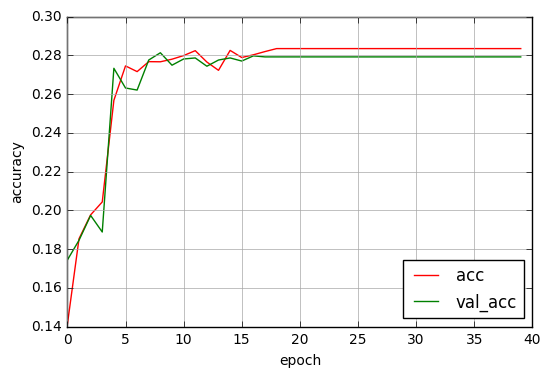

1760/1870 [===========================>..] - ETA: 0sTest score: 10.2483505836
Test accuracy: 0.364171123186


In [142]:
plot_history(history_1)
score = model_a.evaluate(x_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Model 2. One more layer

In [9]:
model_2 = Sequential([
        Flatten(input_shape=img_shape),
        Dense(1024, activation='tanh'),
        Dense(10, activation='softmax'),
        
    ])
model_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model_2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 784)           0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          803840      flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 10)            10250       dense_1[0][0]                    
Total params: 814090
____________________________________________________________________________________________________


In [10]:
history_2 = model_2.fit(x_train, y_train, batch_size=128, nb_epoch=40, verbose=1, 
            validation_data=(x_validate, y_validate))

Train on 14984 samples, validate on 1870 samples
Epoch 1/40
14984/14984 [==============================] - 5s - loss: 0.8682 - acc: 0.7605 - val_loss: 0.6497 - val_acc: 0.8348
Epoch 2/40
14984/14984 [==============================] - 4s - loss: 0.5242 - acc: 0.8623 - val_loss: 0.5649 - val_acc: 0.8540
Epoch 3/40
14984/14984 [==============================] - 4s - loss: 0.4688 - acc: 0.8765 - val_loss: 0.5371 - val_acc: 0.8583
Epoch 4/40
14984/14984 [==============================] - 4s - loss: 0.4323 - acc: 0.8845 - val_loss: 0.4911 - val_acc: 0.8717
Epoch 5/40
14984/14984 [==============================] - 4s - loss: 0.4105 - acc: 0.8936 - val_loss: 0.4732 - val_acc: 0.8770
Epoch 6/40
14984/14984 [==============================] - 6s - loss: 0.3957 - acc: 0.8967 - val_loss: 0.4785 - val_acc: 0.8749
Epoch 7/40
14984/14984 [==============================] - 5s - loss: 0.3873 - acc: 0.8966 - val_loss: 0.4802 - val_acc: 0.8684
Epoch 8/40
14984/14984 [==============================] - 4s -

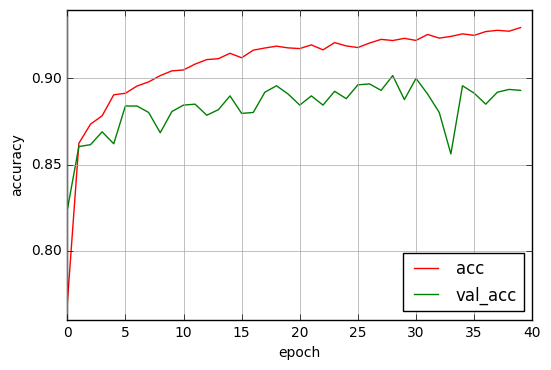

1870/1870 [==============================] - 0s     
Test score: 0.33754558882
Test accuracy: 0.912834224599


In [146]:
plot_history(history_2)
score = model_2.evaluate(x_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Model 3. Add convolution

In [11]:
from keras.layers.convolutional import Convolution2D
model_3 = Sequential([
        Convolution2D(32, 5, 5, activation='relu', border_mode='valid', subsample=(2, 2), input_shape=(1, 28, 28)),
        Flatten(),
        Dense(1024, activation='tanh'),
        Dense(10, activation='softmax')])
model_3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model_3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 12, 12)    832         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 4608)          0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 1024)          4719616     flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 10)            10250       dense_3[0][0]                    
Total params: 4730698
_____________________________________________________________________

In [12]:
history_3 = model_3.fit(x_train.reshape(len(x_train), 1, 28, 28), y_train,
                    batch_size=128, nb_epoch=40, verbose=1,
                    validation_data=(x_validate.reshape(len(x_validate), 1, 28, 28), y_validate))

Train on 14984 samples, validate on 1870 samples
Epoch 1/40
14984/14984 [==============================] - 31s - loss: 0.9166 - acc: 0.7440 - val_loss: 0.9599 - val_acc: 0.6824
Epoch 2/40
14984/14984 [==============================] - 30s - loss: 0.6480 - acc: 0.8397 - val_loss: 0.6498 - val_acc: 0.8171
Epoch 3/40
14984/14984 [==============================] - 32s - loss: 0.5414 - acc: 0.8647 - val_loss: 0.5722 - val_acc: 0.8519
Epoch 4/40
14984/14984 [==============================] - 30s - loss: 0.4650 - acc: 0.8798 - val_loss: 0.5513 - val_acc: 0.8524
Epoch 5/40
14984/14984 [==============================] - 35s - loss: 0.4146 - acc: 0.8905 - val_loss: 0.6879 - val_acc: 0.7711
Epoch 6/40
14984/14984 [==============================] - 33s - loss: 0.3671 - acc: 0.8997 - val_loss: 0.4814 - val_acc: 0.8610
Epoch 7/40
14984/14984 [==============================] - 31s - loss: 0.3380 - acc: 0.9087 - val_loss: 0.4795 - val_acc: 0.8647
Epoch 8/40
14984/14984 [==============================]

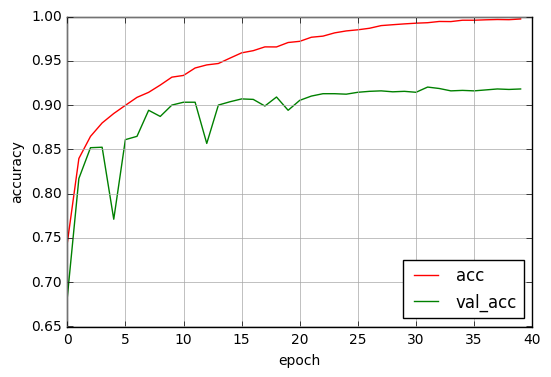

1870/1870 [==============================] - 2s     
Test score: 0.289792260591
Test accuracy: 0.916042780812


In [14]:
plot_history(history_3)
score = model_3.evaluate(x_test.reshape(len(x_test), 1, 28, 28), y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Model 4

In [17]:
from keras.layers.pooling import MaxPooling2D

model_4 = Sequential([
        Convolution2D(32, 5, 5, activation='relu', border_mode='valid', subsample=(2, 2), input_shape=(1, 28, 28)),
        MaxPooling2D(strides=(1, 1)),
        Flatten(),
        Dense(1024, activation='tanh'),
        Dense(10, activation='softmax')
    ])
model_4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [18]:
history_4 = model_4.fit(x_train.reshape(len(x_train), 1, 28, 28), y_train,
                    batch_size=128, nb_epoch=40, verbose=1,
                    validation_data=(x_validate.reshape(len(x_validate), 1, 28, 28), y_validate))

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '763' (I am process '3521')


Train on 14984 samples, validate on 1870 samples
Epoch 1/40
14984/14984 [==============================] - 38s - loss: 1.2257 - acc: 0.6436 - val_loss: 1.5387 - val_acc: 0.4449
Epoch 2/40
14984/14984 [==============================] - 49s - loss: 0.9548 - acc: 0.7432 - val_loss: 0.9629 - val_acc: 0.7358
Epoch 3/40
14984/14984 [==============================] - 49s - loss: 0.8650 - acc: 0.7830 - val_loss: 1.3131 - val_acc: 0.5973
Epoch 4/40
14984/14984 [==============================] - 39s - loss: 0.8244 - acc: 0.8014 - val_loss: 0.9496 - val_acc: 0.6866
Epoch 5/40
14984/14984 [==============================] - 35s - loss: 0.7697 - acc: 0.8164 - val_loss: 0.9166 - val_acc: 0.7342
Epoch 6/40
14984/14984 [==============================] - 30s - loss: 0.6593 - acc: 0.8391 - val_loss: 0.6400 - val_acc: 0.8267
Epoch 7/40
14984/14984 [==============================] - 34s - loss: 0.5880 - acc: 0.8527 - val_loss: 0.7054 - val_acc: 0.7909
Epoch 8/40
14984/14984 [==============================]

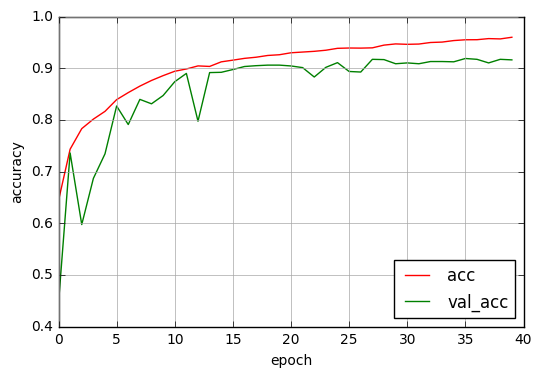

1870/1870 [==============================] - 2s     
Test score: 0.289931933638
Test accuracy: 0.910695186975


In [19]:
plot_history(history_4)
score = model_4.evaluate(x_test.reshape(len(x_test), 1, 28, 28), y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Model 5

In [20]:
from keras.layers.core import Dropout

model_5 = Sequential([
        Convolution2D(32, 5, 5, activation='relu', border_mode='valid', subsample=(2, 2), input_shape=(1, 28, 28)),
        MaxPooling2D(strides=(1, 1)),
        Flatten(),
        Dense(1024, activation='tanh'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
model_5.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [21]:
history_5 = model_5.fit(x_train.reshape(len(x_train), 1, 28, 28), y_train,
                    batch_size=128, nb_epoch=40, verbose=1,
                    validation_data=(x_validate.reshape(len(x_validate), 1, 28, 28), y_validate))

Train on 14984 samples, validate on 1870 samples
Epoch 1/40
14984/14984 [==============================] - 30s - loss: 1.5224 - acc: 0.4944 - val_loss: 1.3702 - val_acc: 0.4989
Epoch 2/40
14984/14984 [==============================] - 34s - loss: 1.3118 - acc: 0.5656 - val_loss: 1.2926 - val_acc: 0.5241
Epoch 3/40
14984/14984 [==============================] - 30s - loss: 1.2007 - acc: 0.6024 - val_loss: 1.0899 - val_acc: 0.6412
Epoch 4/40
14984/14984 [==============================] - 29s - loss: 1.1372 - acc: 0.6289 - val_loss: 1.1277 - val_acc: 0.6037
Epoch 5/40
14984/14984 [==============================] - 31s - loss: 1.0887 - acc: 0.6484 - val_loss: 0.9329 - val_acc: 0.6995
Epoch 6/40
14984/14984 [==============================] - 29s - loss: 0.8519 - acc: 0.7473 - val_loss: 0.8726 - val_acc: 0.6984
Epoch 7/40
14984/14984 [==============================] - 29s - loss: 0.7041 - acc: 0.8011 - val_loss: 0.5507 - val_acc: 0.8455
Epoch 8/40
14984/14984 [==============================]

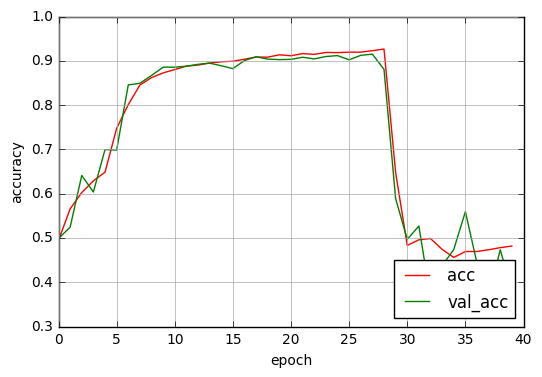

1870/1870 [==============================] - 2s     
Test score: 2.11167029009
Test accuracy: 0.365775401133


In [22]:
plot_history(history_5)
score = model_5.evaluate(x_test.reshape(len(x_test), 1, 28, 28), y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [23]:
model_6 = Sequential([
        Convolution2D(32, 5, 5, activation='relu', border_mode='valid', subsample=(2, 2), input_shape=(1, 28, 28)),
        MaxPooling2D(strides=(1, 1)),
        Convolution2D(4, 3, 3, activation='relu', border_mode='valid', subsample=(1, 1)),
        MaxPooling2D(strides=(1, 1)),
        Flatten(),
        Dense(1024, activation='tanh'),
        Dropout(0.5),
        Dense(10, activation='softmax')])
model_6.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [24]:
history_6 = model_6.fit(x_train.reshape(len(x_train), 1, 28, 28), y_train,
                    batch_size=128, nb_epoch=4, verbose=1,
                    validation_data=(x_validate.reshape(len(x_validate), 1, 28, 28), y_validate))

Train on 14984 samples, validate on 1870 samples
Epoch 1/4
14984/14984 [==============================] - 27s - loss: 1.9084 - acc: 0.4010 - val_loss: 1.6531 - val_acc: 0.4807
Epoch 2/4
14984/14984 [==============================] - 27s - loss: 1.3798 - acc: 0.5512 - val_loss: 1.6261 - val_acc: 0.5091
Epoch 3/4
14984/14984 [==============================] - 26s - loss: 1.2423 - acc: 0.6032 - val_loss: 0.8313 - val_acc: 0.7668
Epoch 4/4
14984/14984 [==============================] - 27s - loss: 1.2197 - acc: 0.6162 - val_loss: 1.2765 - val_acc: 0.5904


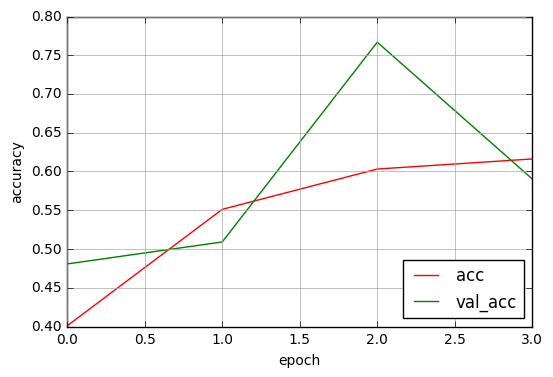

1856/1870 [============================>.] - ETA: 0sTest score: 1.30612465902
Test accuracy: 0.579679144576


In [25]:
plot_history(history_6)
score = model_6.evaluate(x_test.reshape(len(x_test), 1, 28, 28), y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])